# Tutorial 2. Generating Attributions

This first part of this tutorial shows how to generate new attribution scores using integrated gradients and SCimilarity. 

The second section details how to integrate new attributions with pre-computed attributions

Before running this tutorial, you need to ...
1. Download the SCimilarity model from https://zenodo.org/records/15729925.
2. Download the cell type-level attributions you are interested in from https://zenodo.org/communities/signature/. For this tutorial, you can download the relevant attributions from https://zenodo.org/records/15794176. The file can be extracted by running "tar -xzf celltype_attributions.tar.gz". This will produce the "celltype_attributions" folder needed for the tutorial below.

In [1]:
from datetime import datetime
import numpy as np
import os
from os.path import join
import pandas as pd
import scanpy as sc
from scipy import sparse

from SIGnature import SIGnature, SCimilarity, Meta
from SIGnature.utils import align_dataset, lognorm_counts
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

## Part 1: Generate Attributions for New Data

#### Load SCimilarity Model and Attributions TileDB

In [2]:
## want to use GPU in SCimilarity model if you are generating attributions
## if you do not have access to gpu, mark use_gpu = False
scim_model_path = "/home/scimilarity_model"  # Path to Scimilarity Model Downloaded from Zenodo (https://zenodo.org/records/15729925)
scim = SCimilarity(model_path=scim_model_path, use_gpu=True)

sig = SIGnature(gene_order=scim.gene_order, model=scim.model, use_gpu=True)

#### Load dataset

Load your custom dataset. This tutorial shows randomly generated cells. 5000 are entirely random and 500 selectively upregulate MS1.

To generate attributions, AnnData needs to be compatible with SCimilarity
1. raw counts in .X and .layers['counts']
2. genes named using HGNC symbols

To use downstream "Meta" object for analysis, AnnData obs needs to include
1. disease label
2. sample label
3. study label
4. tissue label

In [3]:
# # load custom
# adata = sc.read_h5ad('your_path')

In [4]:
def generate_random_cell(
    n_genes, high_gene_indices=None, high_level_range=(5, 10), rs=114
):
    """
    Generate a random cell with counts, ensuring modest randomized high levels for specific genes.

    Parameters:
    - n_genes: int, total number of genes.
    - high_gene_indices: list of ints, indices of genes to set to high levels (default: None).
    - high_level_range: tuple, range of high levels (default: (5, 10)).
    - rs: int, random seed for reproducibility.

    Returns:
    - counts_zinb: array of gene counts.
    """
    np.random.seed(rs)

    # Generate random counts using Zero-Inflated Negative Binomial (ZINB)
    counts_zinb = np.random.negative_binomial(n=1, p=0.1, size=n_genes)
    zero_mask = np.random.random(n_genes) < 0.8  # 80% zeros (typical for scRNA-seq)
    counts_zinb[zero_mask] = 0

    # Set randomized high count levels for specific gene indices
    if high_gene_indices is not None:
        high_levels = np.random.randint(
            low=high_level_range[0],
            high=high_level_range[1] + 1,
            size=len(high_gene_indices),
        )
        counts_zinb[high_gene_indices] = high_levels

    return counts_zinb

In [5]:
## generate 5000 random cells
ng = 28231  # Number of genes
nc = 5000  # Number of cells

count_list = [generate_random_cell(ng, rs=i) for i in range(nc)]

In [6]:
## generate 500 random cells with high MS1 gene counts
ms1_genes = ['S100A8', 'S100A12', 'RETN', 'CLU', 'MCEMP1', 'IL1R2', 'CYP1B1', 'SELL', 'ALOX5AP', 'SLC39A8', 'PLAC8', 'ACSL1', 'CD163', 'VCAN', 'HP', 'CTSD', 'LGALS1', 'THBS1', 'CES1', 'S100P', 'ANXA6', 'VNN2', 'NAMPT', 'HAMP', 'DYSF', 'SDF2L1', 'NFE2', 'SLC2A3', 'BASP1', 'ADGRG3', 'SOD2', 'CTSA', 'PADI4', 'CALR', 'SOCS3', 'NKG7', 'FLOT1', 'IL1RN', 'ZDHHC19', 'LILRA5', 'ASGR2', 'FAM65B', 'MNDA', 'STEAP4', 'NCF4', 'LBR', 'RP11-295G20.2', 'UBR4', 'PADI2', 'NCF1', 'LINC00482', 'RUNX1', 'RRP12', 'HSPA1A', 'FLOT2', 'ANPEP', 'CXCR1', 'ECE1', 'ADAM19', 'RP11-196G18.3', 'IL4R', 'DNAJB11', 'FES', 'MBOAT7', 'SNHG25', 'RP1-55C23.7', 'CPEB4', 'PRR34-AS1', 'HSPA1B', 'LINC01001', 'C1QC', 'SBNO2', 'GTSE1', 'FOLR3', 'STAB1', 'PLK1', 'HYI-AS1', 'LINC01281', 'TNNT1', 'AC097495.2', 'CTB-35F21.5', 'C19orf35', 'AC109826.1', 'RP11-800A3.7', 'LILRA6', 'PDLIM7', 'NPLOC4', 'C15orf48', 'APOBR', 'CSF2RB', 'CTD-2105E13.14', 'C1QB', 'RP11-123K3.9', 'IQGAP3', 'GAPLINC', 'CTC-490G23.2', 'JAK3', 'CTC-246B18.10', 'MYO5B']

gene_list = sig.check_genes(ms1_genes)
ms1_idx = [scim.gene_order.index(x) for x in gene_list]

The following genes are not included: RP11-196G18.3,FAM65B,CTC-246B18.10,RP1-55C23.7,CTD-2105E13.14,RP11-123K3.9,CTB-35F21.5,HYI-AS1,AC097495.2,RP11-295G20.2,C19orf35,CTC-490G23.2,RP11-800A3.7


In [7]:
## generate 500 cells with high gene counts in MS1 genes
ncl = 500
count_list_ms1 = [
    generate_random_cell(ng, high_gene_indices=ms1_idx, high_level_range=(10, 40), rs=i)
    for i in range(ncl)
]

In [8]:
## combine count matrices
full_count_list = count_list + count_list_ms1
count_mat = np.vstack(full_count_list)

In [9]:
## Convert to AnnData
adata = sc.AnnData(count_mat)
adata.layers["counts"] = count_mat
adata.var = pd.DataFrame(index=scim.gene_order)
adata.obs = pd.DataFrame(index=range(adata.shape[0]))
## add disease labels for random cells and MS1 cells
adata.obs["disease"] = ["Condition 1" for _ in range(nc)] + [
    "Condition 2" for _ in range(ncl)
]
## add sample labels for each condition
adata.obs["sample"] = ["Sample " + str(int(x / 100)) for x in range(adata.obs.shape[0])]
adata.layers["counts"] = sparse.csr_matrix(count_mat)
## need to include sample, study, disease, and tissue to use standard "Meta" functions
adata.obs["study"] = "Test Study"
adata.obs["tissue"] = "Test Tissue"

#### Align Dataset to SCimilarity Genes

Attributions collected against SCimilarity model need to be aligned to SCimilarity gene order and then log-normalized

In [10]:
adata = align_dataset(adata, target_gene_order=scim.gene_order)

In [11]:
adata = lognorm_counts(adata)

#### Generate attributions
Buffer size controls how many cells processed at once. Can adjust to fit on GPU

In [12]:
start = datetime.now()
att = sig.calculate_attributions(X=adata.X, buffer_size=1000)

## if you want to directly save npz_file, run below
# npz_file='custom_data.npz'
# att = sig.calculate_attributions(X=adata.X, buffer_size=1000, npz_path=npz_file)
stop = datetime.now()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


In [13]:
print(stop - start)  # ~10 seconds for the 5500 cells on GPU

0:00:09.825051


In [14]:
att[0].toarray()

array([[0.1875074, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [15]:
adata.X[0].toarray()

array([[1.2711536, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [17]:
## save attributions if not saved above
npz_file = "custom_data.npz"
sparse.save_npz(matrix=att, file=npz_file)

## Part 2: Integrate new data with pre-computed attributions

#### Create a tiledb for integrating with known matrices

In [18]:
# overwrite will take tiledb with same name [custom_tiledb] and overwrite it with your new one
sig.create_tiledb(npz_path=npz_file', overwrite=True, attribution_tiledb_uri='custom_data')

Optimizing custom_data
Fragments before consolidation: 1
Fragments after consolidation: 1


In [19]:
len(ms1_idx)

86

#### Search existing tiledbs and new tiledb

In [20]:
ct_base = "/home/celltype_attributions"  # Path to cell type attributions downloaded from Zenodo (https://zenodo.org/records/15794176)
all_ct = os.listdir(ct_base)

In [21]:
# analyze all monocyte/macrophage cell populations in database
ctoi = [
    "alveolar macrophage",
    "classical monocyte",
    "intermediate monocyte",
    "macrophage",
    "non-classical monocyte",
]

#### Check genes

In [22]:
gene_list = sig.check_genes(ms1_genes)

The following genes are not included: RP11-196G18.3,FAM65B,CTC-246B18.10,RP1-55C23.7,CTD-2105E13.14,RP11-123K3.9,CTB-35F21.5,HYI-AS1,AC097495.2,RP11-295G20.2,C19orf35,CTC-490G23.2,RP11-800A3.7


#### Calculate SIGnature Scores for each Cell Type

Iterate through tiledb of each cell type, calculate score, concatenate the metadata

In [23]:
score_name = "MS1"

In [24]:
meta_list = []
for ct in tqdm(ctoi):
    ## get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## example including weights
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True, aggregate_type='mean', weights = weight_list, attribution_tiledb_uri=att_tdb_path)

    ## example getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False, attribution_tiledb_uri=att_tdb_path)

    ## load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.21s/it]


#### load in new data

In [25]:
big_meta = pd.concat(meta_list)

In [26]:
momac_meta = Meta(big_meta)

In [27]:
momac_meta.subset_invivo()

In [28]:
momac_meta.subset_hq()

In [29]:
## calculate
results = sig.query_attributions(
    gene_list,
    return_aggregate=True,
    aggregate_type="mean",
    attribution_tiledb_uri="custom_data",
)

## load corresponding cell metadata
nmeta = adata.obs
nmeta

## put score
nmeta[score_name] = results

#### Integrate datasets and clean disease names

In [30]:
momac_meta.append(nmeta)

In [31]:
figure_disname_dict = {
    "atopic eczema": "Atopic Dermatitis",
    "COVID-19;healthy": "COVID-19 & Healthy (Mixed)",
    "Epstein-Barr virus infection;hemophagocytic syndrome": "EBV-Associated HLH",
    "Immune dysregulation-polyendocrinopathy-enteropathy-X-linked syndrome": "IPEX",
    "mucocutaneous lymph node syndrome": "Kawasaki Disease",
    "systemic scleroderma;interstitial lung disease": "SSC-ILD",
    "thrombocytopenia": "Severe Fever Thrombocytopenia Syndrome",
}

momac_meta.df["disease"] = [
    figure_disname_dict.get(x, x) for x in momac_meta.df["disease"]
]

#### Calculate hit percentage per sample

In [32]:
# define hits
hit_col = "MS1"
## 90th percentile
momac_meta.add_hits(
    column_name=hit_col,
    mode="percentile",
    cut_val=90,
    hit_type="above",
    string_append="__hit90p",
)

In [33]:
# calculate hits per sample
samphit_df_90 = momac_meta.samphit_df(
    cell_min=25, samp_min=3, hit_col="MS1__hit90p", num_dis=100
)

#### Plot top diseases by mean hit percentage

Condition 2 (initialized with MS1-like cells) shows high levels, but Condition 1 (which was initialized random counts) is very low

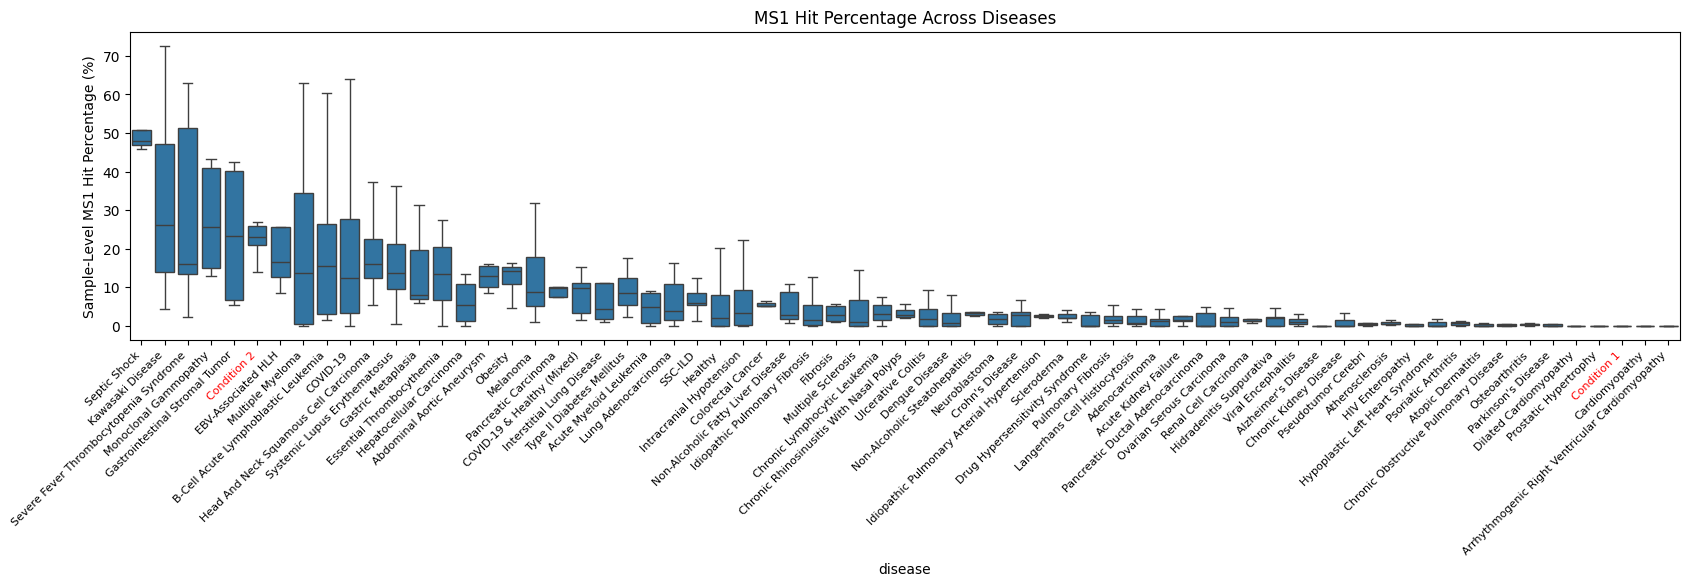

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 4))
sns.boxplot(data=samphit_df_90, x="disease", y="MS1__hit90p", showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)

for label in ax.get_xticklabels():
    if label.get_text() in ["Condition 1", "Condition 2"]:
        label.set_color("red")
ax.set_title("MS1 Hit Percentage Across Diseases")
ax.set_ylabel("Sample-Level MS1 Hit Percentage (%)")

y_ticks = ax.get_yticks() * 100
ax.set_yticklabels([f"{int(y)}" for y in y_ticks]);